In [1]:
!pip install -q opencv-python


[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install moviepy


[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import cv2
#from google.colab.patches import cv2_imshow
# Libraries needed to edit/save/watch video clips
from moviepy import editor
import moviepy


In [4]:
def process_video(test_video, output_video):
    """
    Read input video stream and produce a video file with detected lane lines.
    Parameters:
        test_video: location of input video file
        output_video: location where output video file is to be saved
    """
    # read the video file using VideoFileClip without audio
    input_video = editor.VideoFileClip(test_video, audio=False)
    fps = input_video.fps if input_video.fps is not None else 30
    # apply the function "frame_processor" to each frame of the video
    # will give more detail about "frame_processor" in further steps
    # "processed" stores the output video
    processed = input_video.fl_image(frame_processor)
    # save the output video stream to an mp4 file
    processed.write_videofile(output_video, audio=False, fps=fps)

In [6]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
    Parameters:
        image: image of a road where one wants to detect lane lines
        (we will be passing frames of video to this function)
    """
    # convert the RGB image to Gray scale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # applying gaussian Blur which removes noise from the image
    # and focuses on our region of interest
    # size of gaussian kernel
    kernel_size = 5
    # Applying gaussian blur to remove noise from the frames
    blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 8)
    # Calculate the median of the pixel intensities
    median_intensity = np.median(blur)
    # Define lower and upper thresholds as a percentage of the median intensity
    low_t = int(max(0, (1.0 - 0.33) * median_intensity))
    high_t = int(min(255, (1.0 + 0.33) * median_intensity))
    # applying canny edge detection and save edges in a variable
    edges = cv2.Canny(blur, low_t, high_t)
    # since we are getting too many edges from our image, we apply
    # a mask polygon to only focus on the road
    # Will explain Region selection in detail in further steps
    region = region_selection(edges)
    # Applying hough transform to get straight lines from our image
    # and find the lane lines
    # Will explain Hough Transform in detail in further steps
    hough = hough_transform(region)
    #lastly we draw the lines on our resulting frame and return it as output
    result = draw_lane_lines(image, lane_lines(image, hough))
    return result

In [13]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
    Parameters:
        image: we pass here the output from canny where we have
        identified edges in the frame
    """
    # create an array of the same size as of the input image
    mask = np.zeros_like(image)
    # if you pass an image with more then one channel
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    # our image only has one channel so it will go under "else"
    else:
          # color of the mask polygon (white)
        ignore_mask_color = 255
    # creating a polygon to focus only on the road in the picture
    # we have created this polygon in accordance to how the camera was placed
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.2, rows * 1]
    top_left     = [cols * 0.4, rows * 0.5]
    bottom_right = [cols * 0.85 , rows * 1]
    top_right    = [cols * 0.6 , rows * 0.5]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    # filling the polygon with white color and generating the final mask
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # performing Bitwise AND on the input image and mask to get only the edges on the road
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [7]:
def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
    Parameter:
        image: grayscale image which should be an output from the edge detector
    """
    # Distance resolution of the accumulator in pixels.
    rho = 5  # Here one means it will check every possible line at each pixel
    # Angle resolution of the accumulator in radians.
    theta = np.pi/180  # means one degree
    # Only lines that are greater than threshold will be returned.
    threshold = 100
    # Line segments shorter than that are rejected.
    minLineLength = 50
    # Maximum allowed gap between points on the same line to link them
    maxLineGap = 500
    # function returns an array containing dimensions of straight lines
    # appearing in the input image
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [12]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
    Parameters:
        lines: output from Hough Transform
    """

    if lines is None:
        return None, None

    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    


    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue # ignore a vertical line
            # calculating slope of a line
            slope = (y2 - y1) / (x2 - x1)
            # calculating intercept of a line
            intercept = y1 - (slope * x1)
            # calculating length of a line
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            # slope of left lane is negative and for right lane slope is positive
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    #
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
   
    if line is None:
        x1 = x2 = y1 = y2 = None
        return None
    slope, intercept = line
    if slope == 0:
        x1 = x2 = None
    
    else:
        try:
            x1 = int((y1 - intercept) / slope)
            x2 = int((y2 - intercept) / slope)
        except OverflowError:
            # Handle the OverflowError if it occurs
            x1 = x2 = None

    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    """
    Create full lenght lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    """The values of y1 and y2 help in defining the length and position of the lane lines.
    They are used to convert the slope and intercept of the detected lane lines into pixel coordinates for drawing."""
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
        Parameters:
            image: The input test image (video frame in our case).
            lines: The output lines from Hough Transform.
            color (Default = red): Line color.
            thickness (Default = 12): Line thickness.
    """
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            if line is not None:
                cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

In [14]:
process_video('try.mp4','outputfinal.mp4')

Moviepy - Building video outputfinal.mp4.
Moviepy - Writing video outputfinal.mp4



Moviepy - Done !
Moviepy - video ready outputfinal.mp4


In [18]:
image_path ="Rail Lanes Detection\sample.png"
image = cv2.imread(image_path)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # applying gaussian Blur which removes noise from the image
    # and focuses on our region of interest
    # size of gaussian kernel
cv2.imshow(grayscale, grayscale)
  # Wait until a key is pressed and close all windows
cv2.waitKey(0)
cv2.destroyAllWindows()
kernel_size = 5
    # Applying gaussian blur to remove noise from the frames
blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 8)
cv2.imshow(blur, blur)
    # first threshold for the hysteresis procedure
low_t = 150
    # second threshold for the hysteresis procedure
high_t = 250
    # applying canny edge detection and save edges in a variable
edges = cv2.Canny(blur, low_t, high_t)
cv2.imshow(edges,edges)
edges.shape

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
def region_selection2(image):
    """
    Determine and cut the region of interest in the input image.
    Parameters:
        image: we pass here the output from canny where we have
        identified edges in the frame
    """
    # create an array of the same size as of the input image
    mask = np.zeros_like(image)
    # if you pass an image with more then one channel
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    # our image only has one channel so it will go under "else"
    else:
          # color of the mask polygon (white)
        ignore_mask_color = 255
    # creating a polygon to focus only on the road in the picture
    # we have created this polygon in accordance to how the camera was placed
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.28, rows * 1]
    top_left     = [cols * 0.4, rows * 0.5]
    bottom_right = [cols * 0.75 , rows * 1]
    top_right    = [cols * 0.6 , rows * 0.5]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    # filling the polygon with white color and generating the final mask
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.imshow(mask, mask)
    # performing Bitwise AND on the input image and mask to get only the edges on the road
    masked_image = cv2.bitwise_and(image, mask)
    cv2.imshow(masked_image, masked_image)
    return masked_image

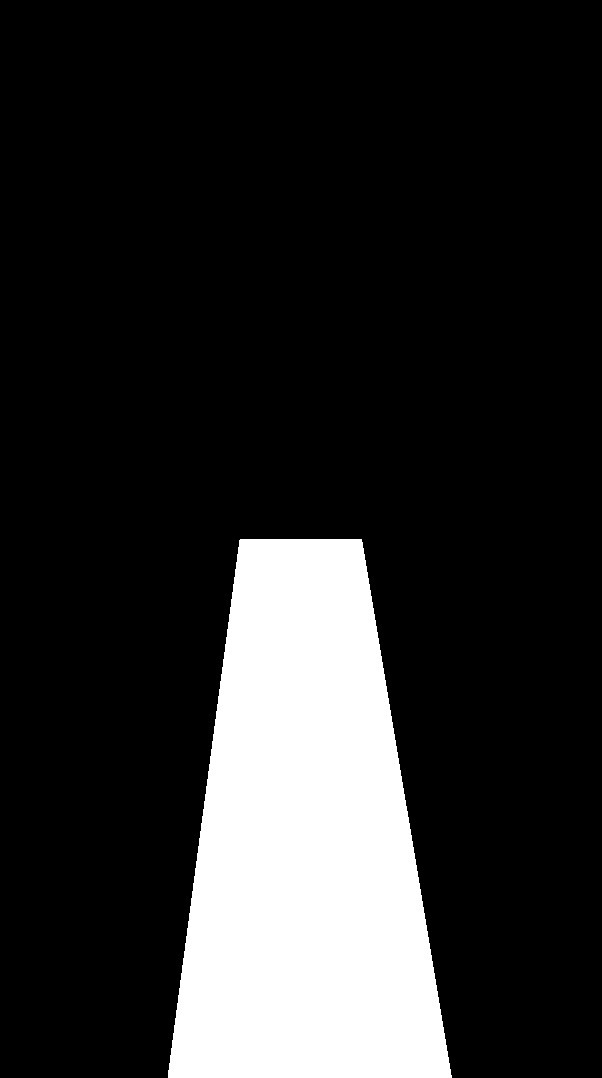

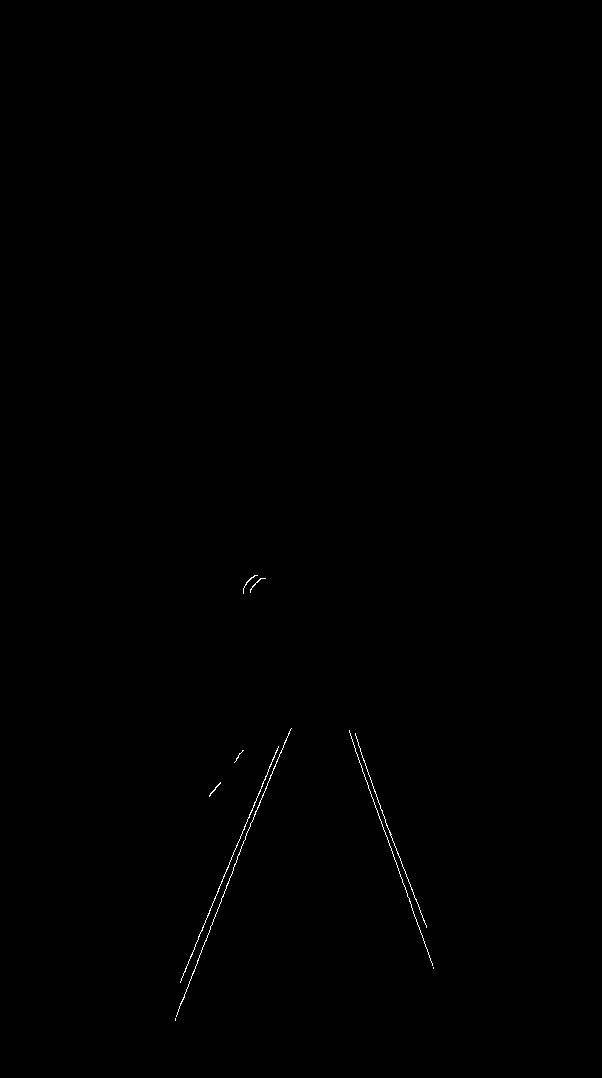

In [ ]:
region = region_selection2(edges)



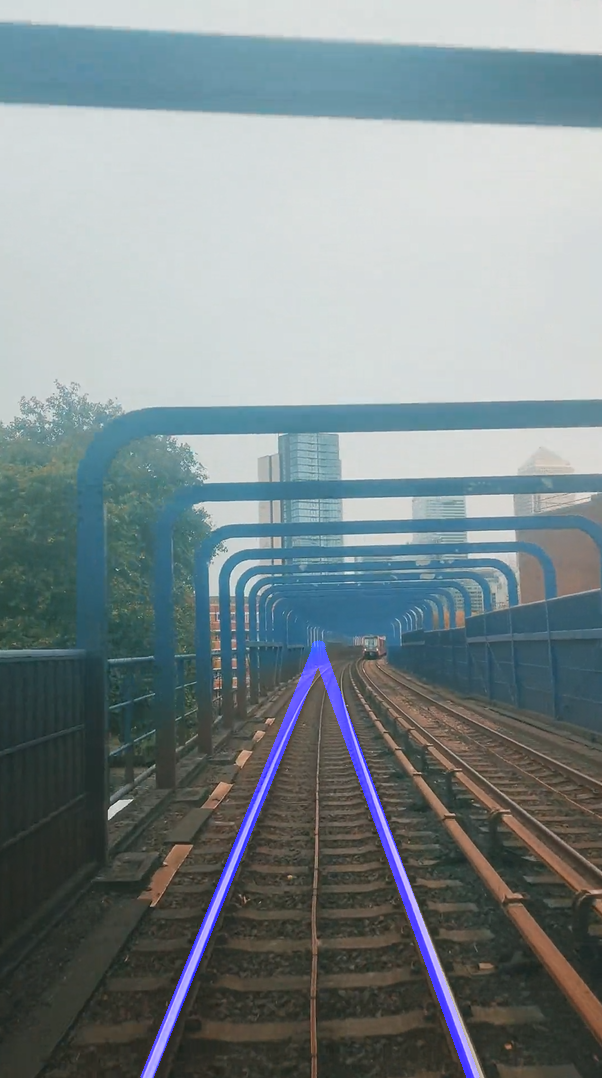

In [ ]:
h2 = hough_transform(region)
result = draw_lane_lines(image, lane_lines(image, h2))
